In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, ConvLSTM2D, Flatten
from sklearn.svm import OneClassSVM
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Load filtered data
# train_df = pd.read_csv('https://raw.githubusercontent.com/IKRAMJAAFAR/DeeL/main/Filtered/filtered_training_scaled.csv')
# valid_df = pd.read_csv('https://raw.githubusercontent.com/IKRAMJAAFAR/DeeL/main/Filtered/filtered_validation_scaled.csv')
# test_df = pd.read_csv('https://raw.githubusercontent.com/IKRAMJAAFAR/DeeL/main/Filtered/filtered_testing_scaled.csv')

# Load unfiltered data
train_df = pd.read_csv('https://raw.githubusercontent.com/IKRAMJAAFAR/DeeL/main/unfiltered/unfiltered_training_scaled.csv')
valid_df = pd.read_csv('https://raw.githubusercontent.com/IKRAMJAAFAR/DeeL/main/unfiltered/unfiltered_validation_scaled.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/IKRAMJAAFAR/DeeL/main/unfiltered/unfiltered_testing_scaled.csv')

In [3]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['value']])
valid_scaled = scaler.transform(valid_df[['value']])
test_scaled = scaler.transform(test_df[['value']])

In [4]:
sequence_length = 30

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 0])
        y.append(data[i+sequence_length, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, sequence_length)
X_valid, y_valid = create_sequences(valid_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [5]:
# Model 1: LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid), verbose=0)

predictions = model.predict(X_test, verbose=0)
errors = np.abs(predictions - y_test)
mse_lstm = np.mean(errors)
threshold = np.percentile(errors, 95)
anomalies_lstm = errors > threshold
normalized_lstm_score = (np.sum(anomalies_lstm) / len(errors)) * 100

# Print Results for LSTM
print(f"LSTM MSE: {mse_lstm:.6f}")
print(f"LSTM Normalized Anomaly Score: {normalized_lstm_score:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM MSE: 0.210877
LSTM Normalized Anomaly Score: 7595.00%


In [6]:
# Model 2: Autoencoder
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=False))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_valid, X_valid), verbose=0)

reconstruction = model.predict(X_test, verbose=0)
reconstruction_error = np.mean(np.abs(reconstruction - X_test), axis=1)
threshold = np.percentile(reconstruction_error, 95)
anomalies_autoencoder = reconstruction_error > threshold

# Print Results for Autoencoder
print(f"Autoencoder Anomalies: {np.sum(anomalies_autoencoder)}")

Autoencoder Anomalies: 76


In [7]:
# Model 3: ConvLSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], sequence_length, 1, 1, 1))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], sequence_length, 1, 1, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, 1))

model = Sequential()
model.add(ConvLSTM2D(64, (3, 3), padding='same', input_shape=(sequence_length, 1, 1, 1), return_sequences=True))
model.add(ConvLSTM2D(64, (3, 3), padding='same', return_sequences=False))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_reshaped, X_train[:, -1], epochs=10, batch_size=64, validation_data=(X_valid_reshaped, X_valid[:, -1]), verbose=0)

predictions = model.predict(X_test_reshaped, verbose=0)
error = np.mean(np.abs(X_test_reshaped[:, :, 0, 0, 0] - predictions), axis=1)
threshold = np.percentile(error, 95)
anomalies_convlstm = error > threshold

# Print Results for ConvLSTM
print(f"ConvLSTM Anomalies: {np.sum(anomalies_convlstm)}")

ConvLSTM Anomalies: 76


In [8]:
# Model 4: One-Class SVM
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_valid_flat = X_valid.reshape((X_valid.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

svm = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
svm.fit(X_train_flat)
predictions = svm.predict(X_test_flat)
anomalies_svm = predictions == -1

# Print Results for One-Class SVM
print(f"One-Class SVM Anomalies: {np.sum(anomalies_svm)}")

One-Class SVM Anomalies: 314


In [9]:
# Model 5: Seasonal Decomposition
series = test_df['value']
decomposition = seasonal_decompose(series, model='additive', period=sequence_length)
residual = decomposition.resid.dropna()
threshold = np.percentile(np.abs(residual), 95)
anomalies_seasonal = np.abs(residual) > threshold

# Print Results for Seasonal Decomposition
print(f"Seasonal Decomposition Anomalies: {np.sum(anomalies_seasonal)}")

Seasonal Decomposition Anomalies: 76


In [10]:
# Model Comparison
results = {
    'LSTM MSE': mse_lstm,
    'LSTM Anomaly Score': normalized_lstm_score,
    'Autoencoder Anomalies': np.sum(anomalies_autoencoder),
    'ConvLSTM Anomalies': np.sum(anomalies_convlstm),
    'One-Class SVM Anomalies': np.sum(anomalies_svm),
    'Seasonal Decomposition Anomalies': np.sum(anomalies_seasonal)
}

for model, score in results.items():
    if 'MSE' in model:
        print(f'{model}: {score:.6f}')
    else:
        percentage = (score / len(errors)) * 100
        print(f'{model}: {score} anomalies ({percentage:.2f}%)')

LSTM MSE: 0.210877
LSTM Anomaly Score: 7594.9967083607635 anomalies (500.00%)
Autoencoder Anomalies: 76 anomalies (5.00%)
ConvLSTM Anomalies: 76 anomalies (5.00%)
One-Class SVM Anomalies: 314 anomalies (20.67%)
Seasonal Decomposition Anomalies: 76 anomalies (5.00%)


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Helper function to calculate performance metrics
def evaluate_anomaly_detection(true_anomalies, predicted_anomalies):
    precision = precision_score(true_anomalies, predicted_anomalies)
    recall = recall_score(true_anomalies, predicted_anomalies)
    f1 = f1_score(true_anomalies, predicted_anomalies)
    auc = roc_auc_score(true_anomalies, predicted_anomalies)
    return precision, recall, f1, auc

# Generate synthetic ground truth anomalies for testing purposes
# This should be replaced with actual ground truth labels if available
true_anomalies = (np.random.rand(len(errors)) < 0.1).astype(int)  # 10% anomalies as an example


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0684 - val_loss: 0.0055
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014 - val_loss: 0.0014


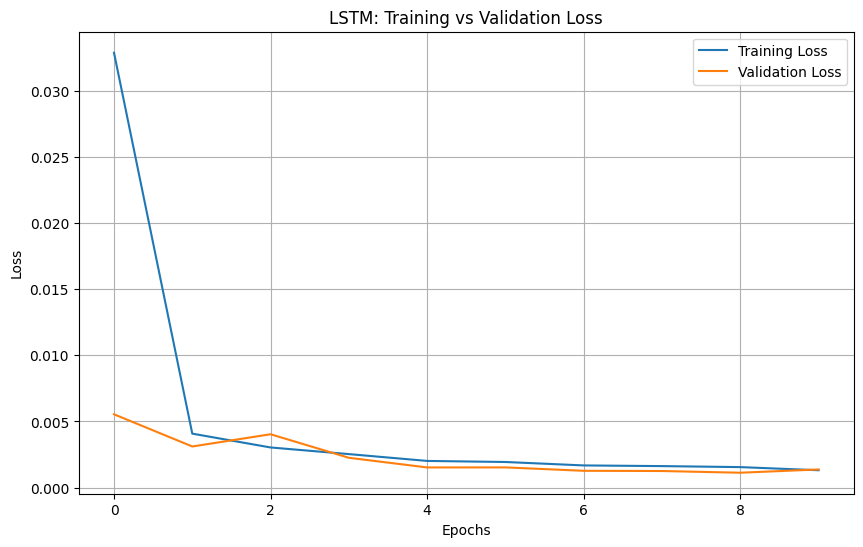

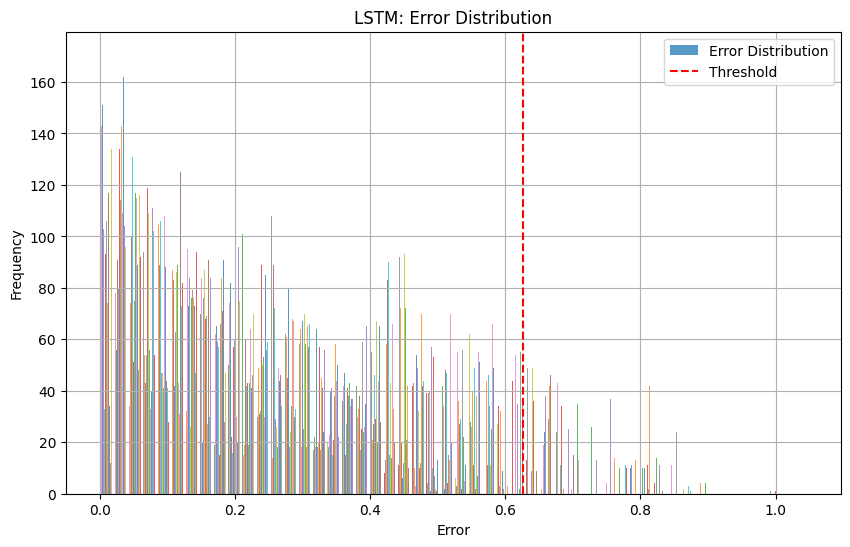

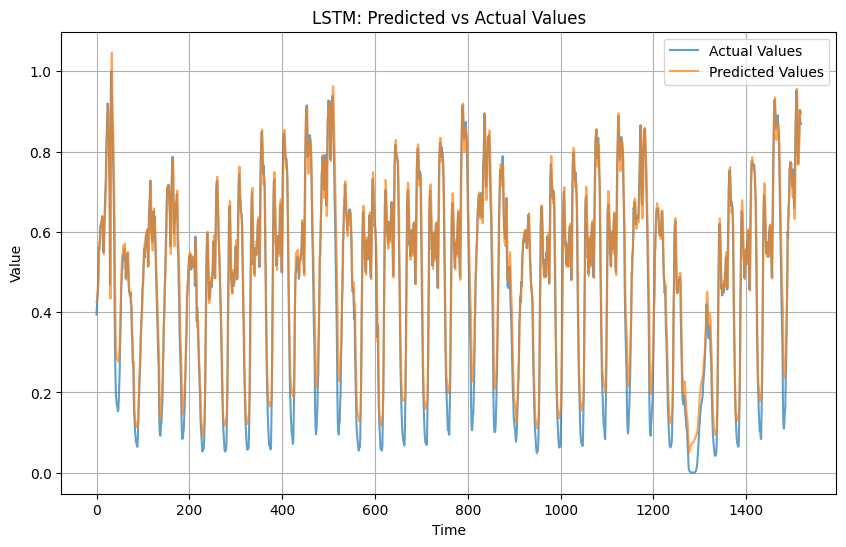

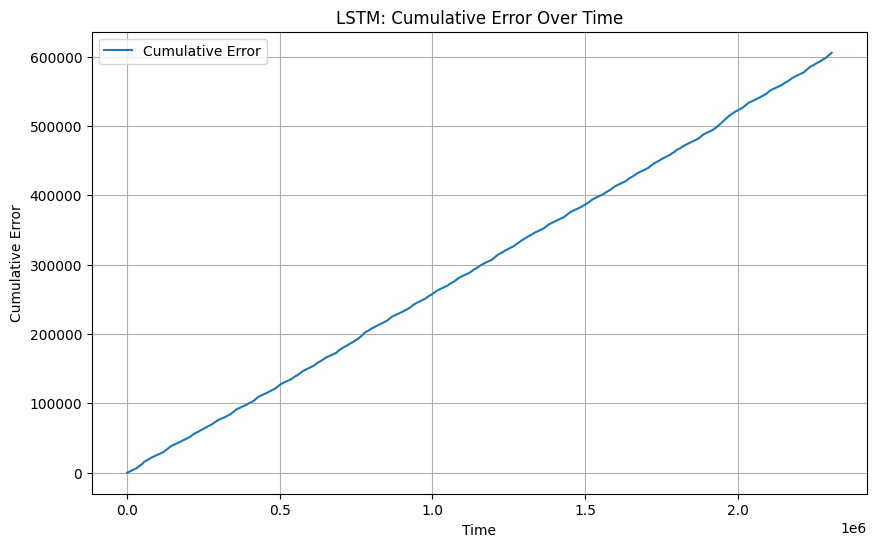

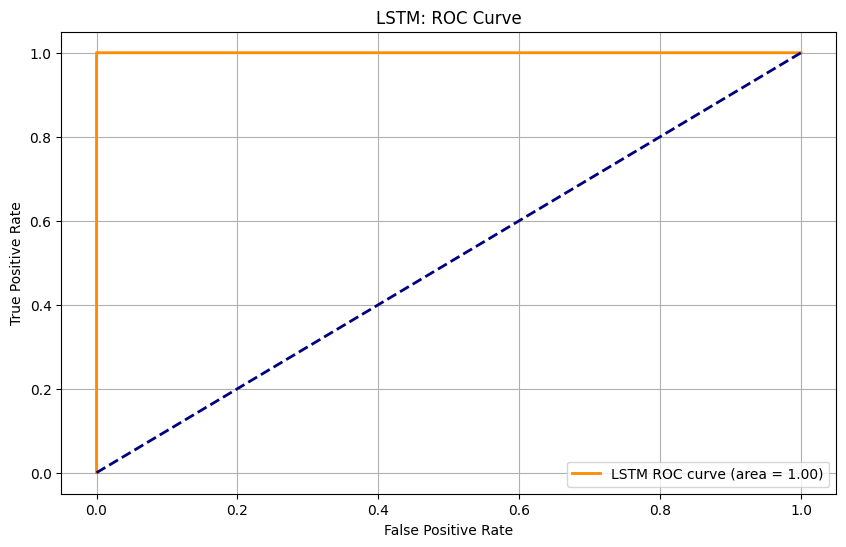

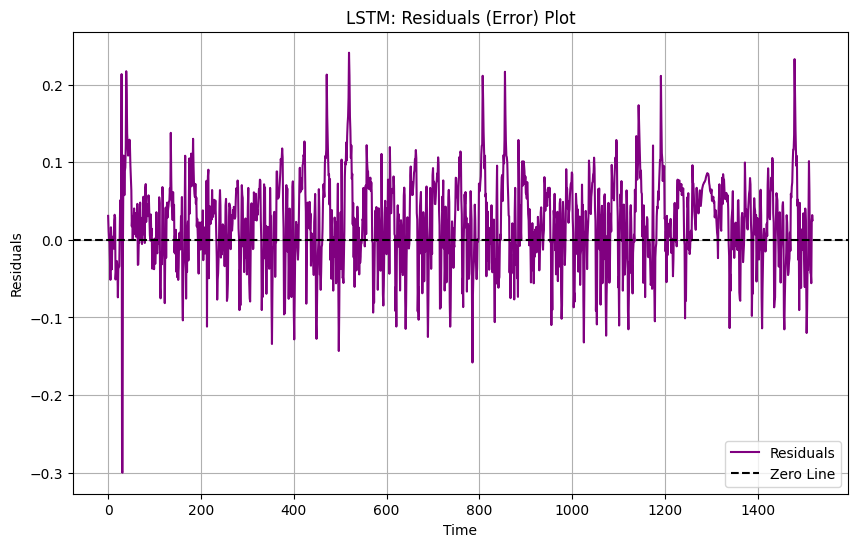

LSTM Mean Error: 0.262533
LSTM Threshold (95th Percentile): 0.626938
LSTM AUC: 1.00


In [37]:
# 1. LSTM Performance Test
# ===============================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Define and Train the LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_valid, y_valid), verbose=1)

# Predictions and Errors
lstm_predictions = lstm_model.predict(X_test, verbose=0)
lstm_errors = np.abs(lstm_predictions - y_test)
lstm_threshold = np.percentile(lstm_errors, 95)

# Visualizations
# 1. Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title("LSTM: Training vs Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(lstm_errors, bins=50, alpha=0.75, label='Error Distribution')
plt.axvline(lstm_threshold, color='red', linestyle='--', label='Threshold')
plt.title("LSTM: Error Distribution")
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# 3. Predicted vs Actual Values (Time Series)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', alpha=0.7)
plt.plot(lstm_predictions, label='Predicted Values', alpha=0.7)
plt.title("LSTM: Predicted vs Actual Values")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# 4. Cumulative Error Plot
plt.figure(figsize=(10, 6))
cumulative_error = np.cumsum(lstm_errors)
plt.plot(cumulative_error, label='Cumulative Error')
plt.title("LSTM: Cumulative Error Over Time")
plt.xlabel('Time')
plt.ylabel('Cumulative Error')
plt.legend()
plt.grid()
plt.show()

# 5. AUC Calculation and ROC Curve
# Assuming true_labels and lstm_errors are defined properly
true_labels = (lstm_errors > lstm_threshold).astype(int).flatten()  # Binary labels for anomaly detection
fpr, tpr, _ = roc_curve(true_labels, lstm_errors.flatten())  # Use flattened errors for AUC
roc_auc = auc(fpr, tpr)

# ROC Curve Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("LSTM: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 6. Residuals Plot (Error - Residuals)
residuals = lstm_predictions.flatten() - y_test.flatten()
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', label='Zero Line')
plt.title("LSTM: Residuals (Error) Plot")
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

# Print Metrics
print(f"LSTM Mean Error: {np.mean(lstm_errors):.6f}")
print(f"LSTM Threshold (95th Percentile): {lstm_threshold:.6f}")
print(f"LSTM AUC: {roc_auc:.2f}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0732 - val_loss: 0.0192
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0169 - val_loss: 0.0110
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0020 - val_loss: 0.0023


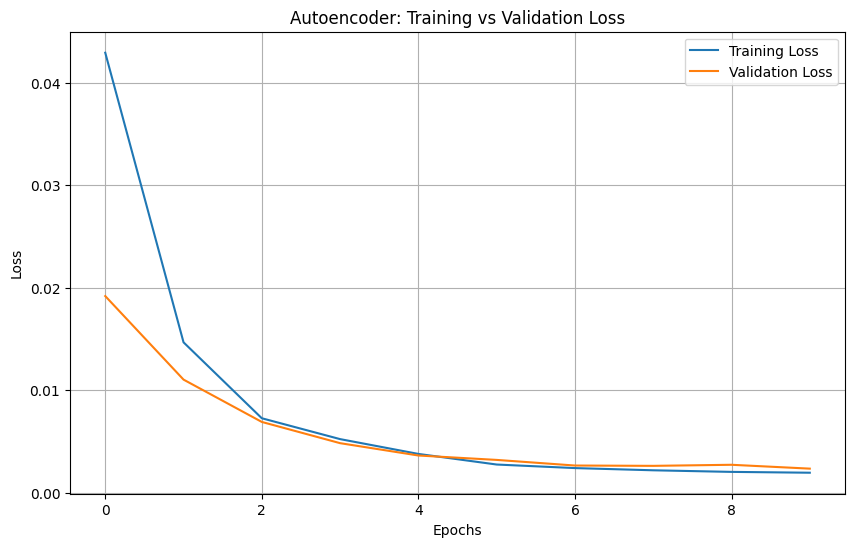

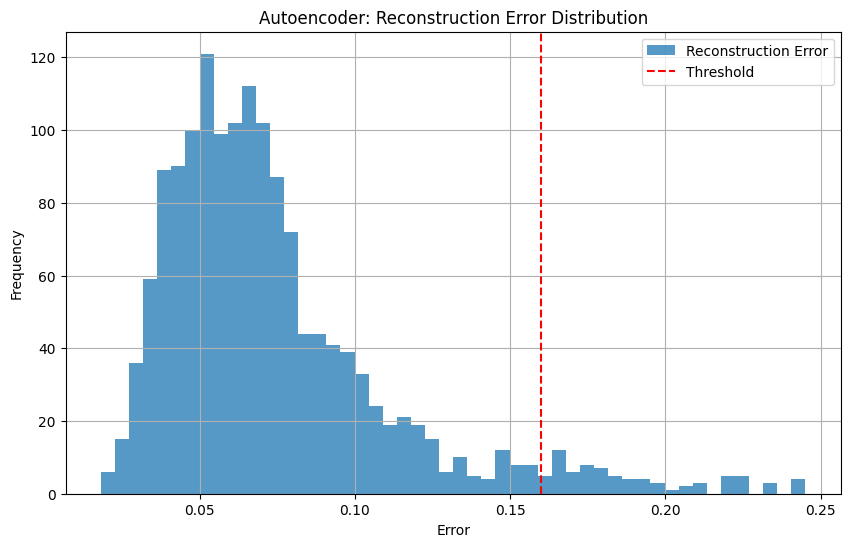

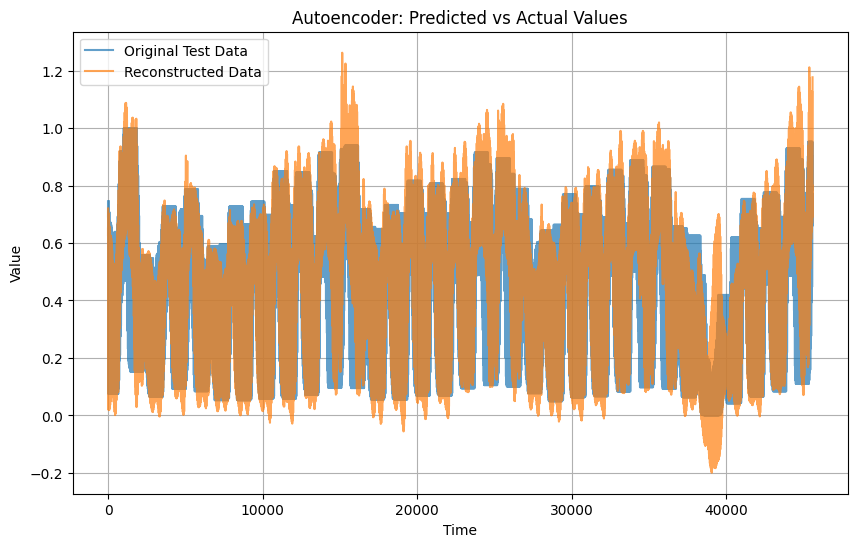

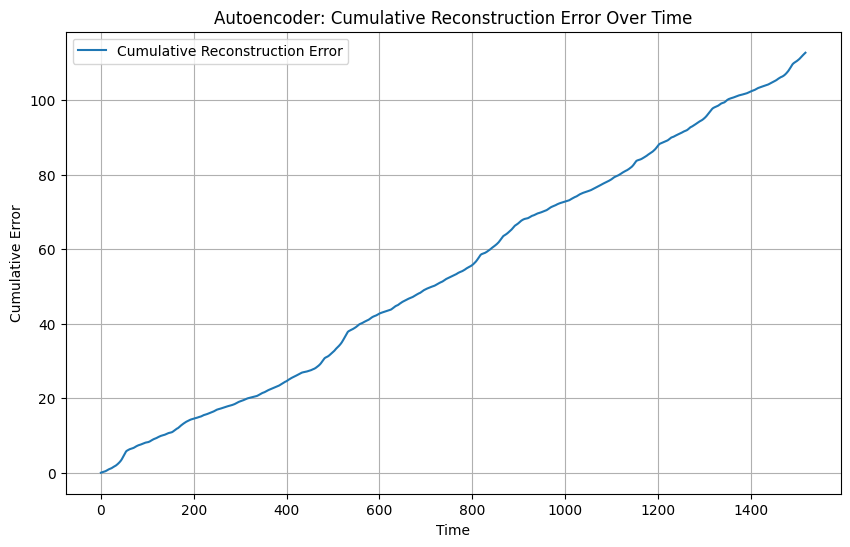

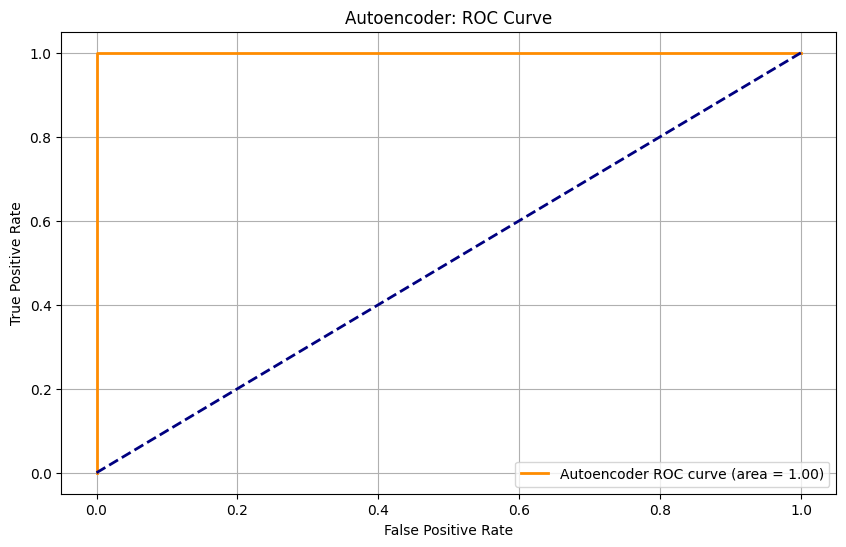

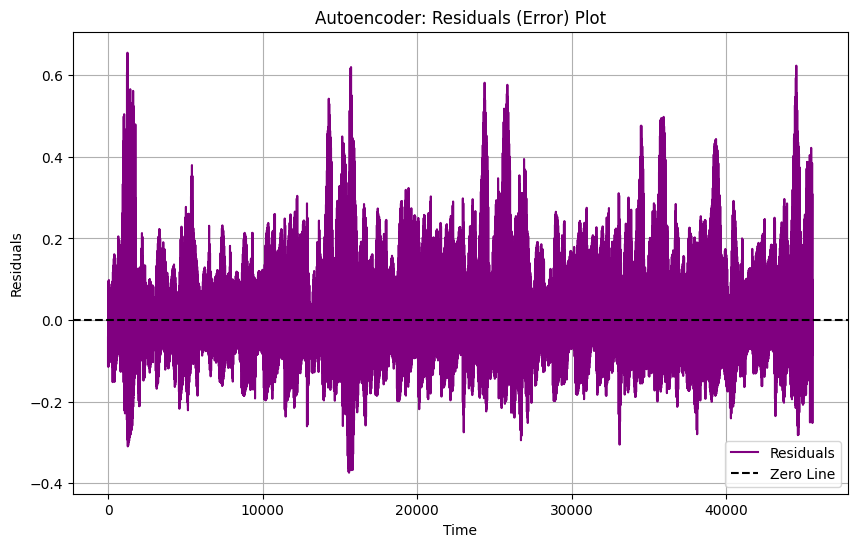

Autoencoder Mean Reconstruction Error: 0.074227
Autoencoder Threshold (95th Percentile): 0.159990
Autoencoder AUC: 1.00


In [39]:
# Model 2: Autoencoder Performance Test
# ===============================

from tensorflow.keras.layers import RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Define and Train the Autoencoder Model
autoencoder_model = Sequential()
autoencoder_model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=False))
autoencoder_model.add(RepeatVector(X_train.shape[1]))
autoencoder_model.add(LSTM(64, activation='relu', return_sequences=True))
autoencoder_model.add(TimeDistributed(Dense(1)))
autoencoder_model.compile(optimizer='adam', loss='mse')

autoencoder_history = autoencoder_model.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_valid, X_valid), verbose=1)

# Reconstruction Errors
autoencoder_reconstruction = autoencoder_model.predict(X_test, verbose=0)
autoencoder_reconstruction_error = np.mean(np.abs(autoencoder_reconstruction - X_test), axis=1)
autoencoder_threshold = np.percentile(autoencoder_reconstruction_error, 95)

# Visualizations
# 1. Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(autoencoder_history.history['loss'], label='Training Loss')
plt.plot(autoencoder_history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder: Training vs Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(autoencoder_reconstruction_error, bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(autoencoder_threshold, color='red', linestyle='--', label='Threshold')
plt.title("Autoencoder: Reconstruction Error Distribution")
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# 3. Predicted vs Actual Values (Reconstruction vs Original Data)
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), label='Original Test Data', alpha=0.7)
plt.plot(autoencoder_reconstruction.flatten(), label='Reconstructed Data', alpha=0.7)
plt.title("Autoencoder: Predicted vs Actual Values")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# 4. Cumulative Reconstruction Error Plot
plt.figure(figsize=(10, 6))
cumulative_error = np.cumsum(autoencoder_reconstruction_error)
plt.plot(cumulative_error, label='Cumulative Reconstruction Error')
plt.title("Autoencoder: Cumulative Reconstruction Error Over Time")
plt.xlabel('Time')
plt.ylabel('Cumulative Error')
plt.legend()
plt.grid()
plt.show()

# 5. AUC Calculation and ROC Curve
# Assuming true_labels are defined properly (binary anomaly labels)
true_labels = (autoencoder_reconstruction_error > autoencoder_threshold).astype(int).flatten()
fpr, tpr, _ = roc_curve(true_labels, autoencoder_reconstruction_error.flatten())  # Flatten error for AUC
roc_auc = auc(fpr, tpr)

# ROC Curve Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Autoencoder ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Autoencoder: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 6. Residuals of Reconstruction
residuals = autoencoder_reconstruction.flatten() - X_test.flatten()
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', label='Zero Line')
plt.title("Autoencoder: Residuals (Error) Plot")
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

# Print Metrics
print(f"Autoencoder Mean Reconstruction Error: {np.mean(autoencoder_reconstruction_error):.6f}")
print(f"Autoencoder Threshold (95th Percentile): {autoencoder_threshold:.6f}")
print(f"Autoencoder AUC: {roc_auc:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 329ms/step - loss: 0.0509 - val_loss: 0.0078
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 322ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - loss: 9.6624e-04 - val_loss: 2.8865e-04
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - loss: 2.3327e-04 - val_loss: 1.2928e-04
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 341ms/step - loss: 1.3615e-04 - val_loss: 7.6798e-05
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - loss: 6.8875e-05 - val_loss: 1.5476e-04
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 342ms/step - loss: 7.2658e-05 - val_loss: 1.2283e-04
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 332ms/step - loss: 4.9044e-05 - val_loss: 2.8881e-05
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 332ms/step - loss: 3.2010e-05 - val_loss: 4.6616e-05


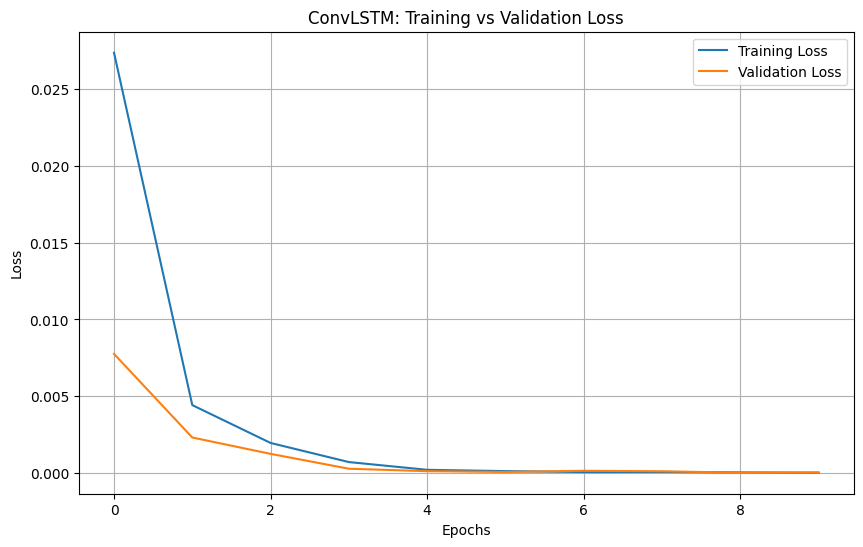

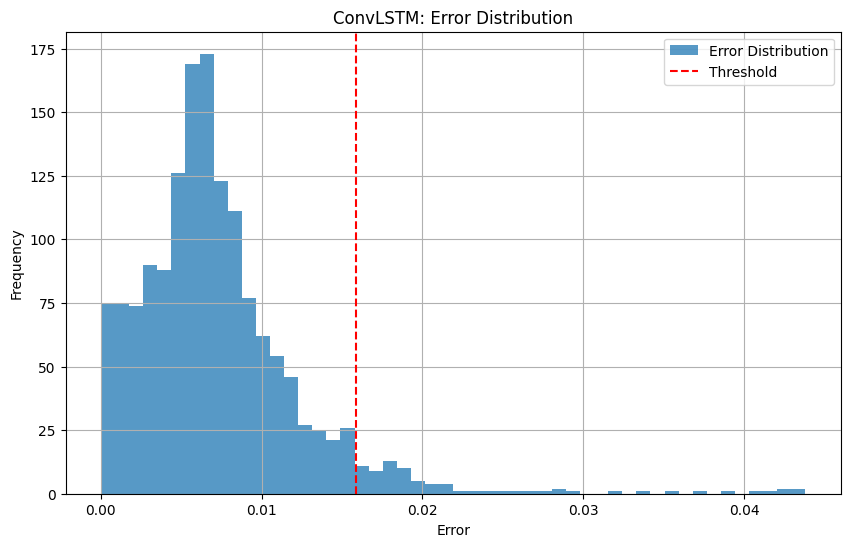

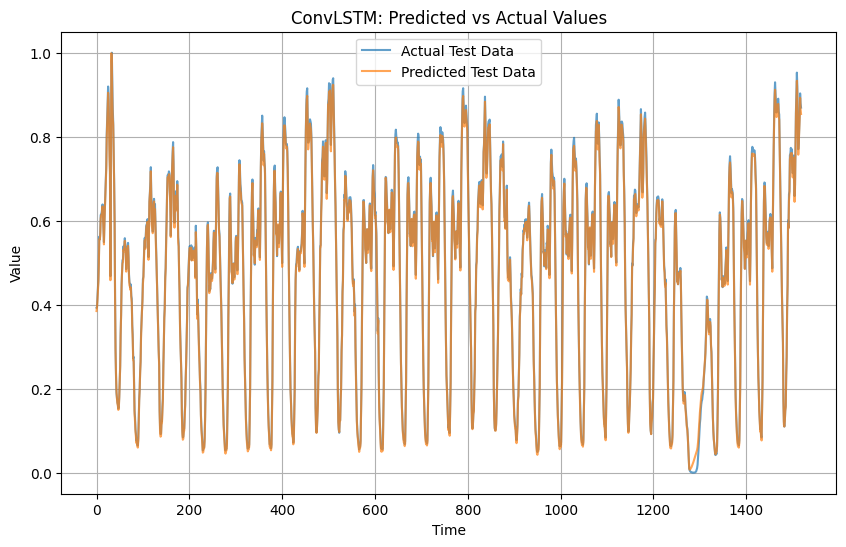

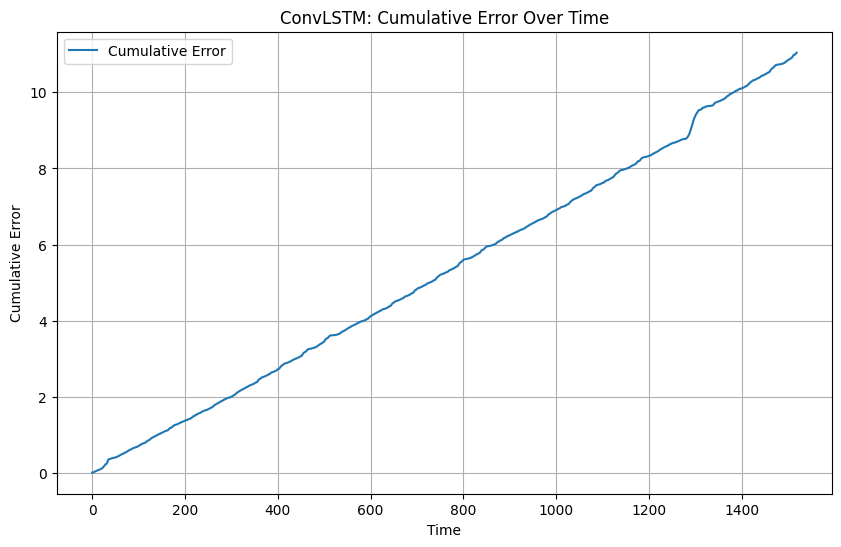

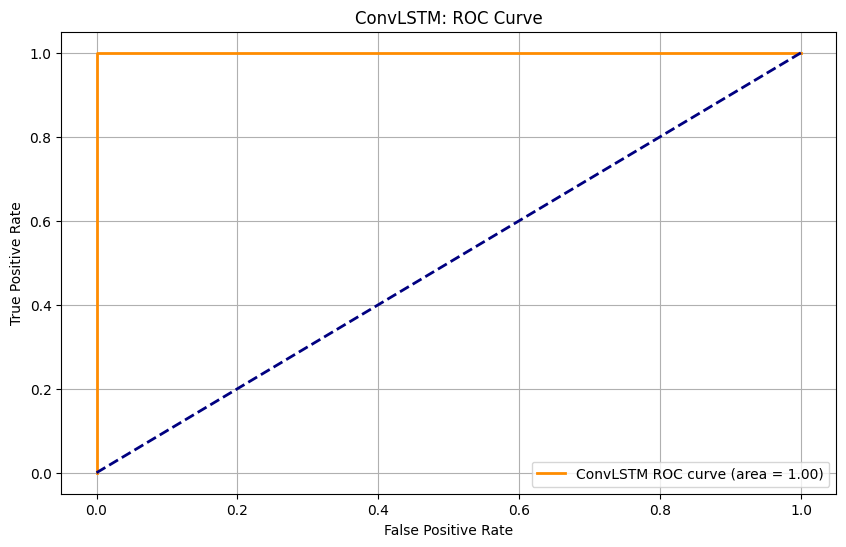

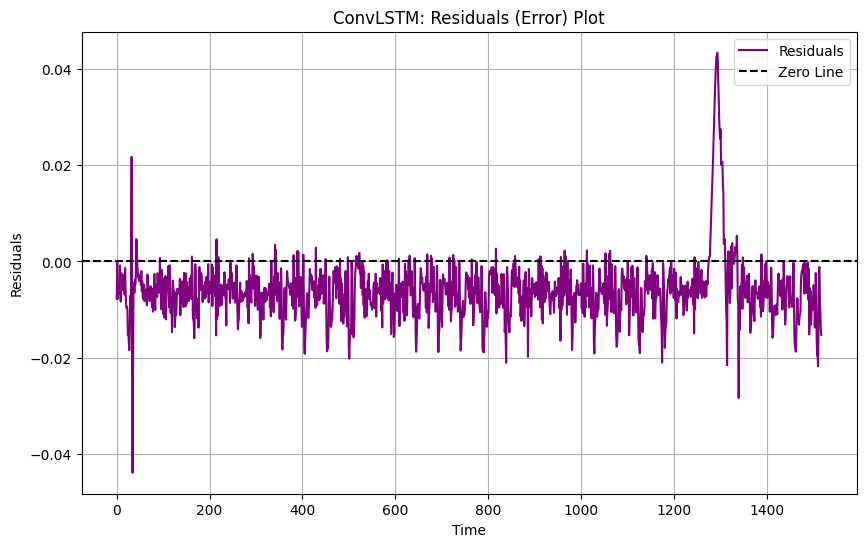

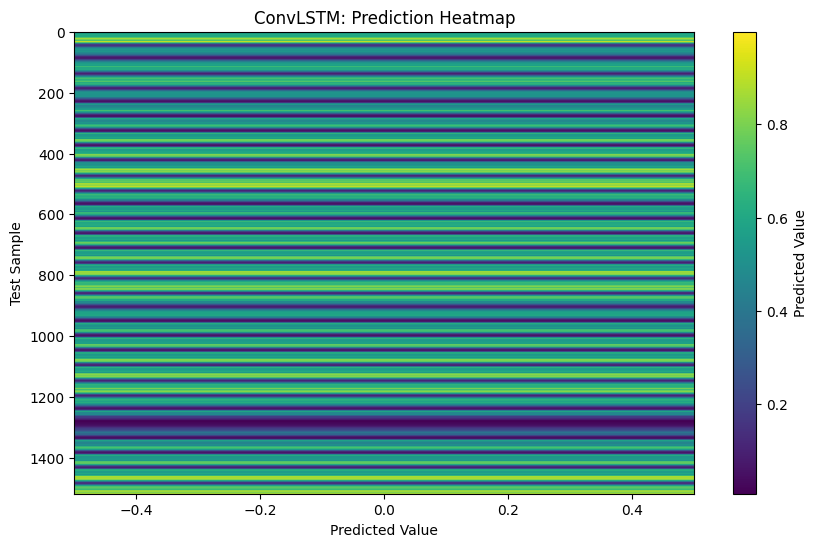

ConvLSTM Mean Error: 0.007267
ConvLSTM Threshold (95th Percentile): 0.015836
ConvLSTM AUC: 1.00


In [41]:
# Model 3: ConvLSTM Performance Test
# ===============================
from tensorflow.keras.layers import ConvLSTM2D, Flatten
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Prepare Data for ConvLSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], sequence_length, 1, 1, 1))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], sequence_length, 1, 1, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, 1))

# Define and Train the ConvLSTM Model
convlstm_model = Sequential()
convlstm_model.add(ConvLSTM2D(64, (3, 3), padding='same', input_shape=(sequence_length, 1, 1, 1), return_sequences=True))
convlstm_model.add(ConvLSTM2D(64, (3, 3), padding='same', return_sequences=False))
convlstm_model.add(Flatten())
convlstm_model.add(Dense(1))
convlstm_model.compile(optimizer='adam', loss='mse')

convlstm_history = convlstm_model.fit(X_train_reshaped, X_train[:, -1], epochs=10, batch_size=64, validation_data=(X_valid_reshaped, X_valid[:, -1]), verbose=1)

# Predictions and Errors
convlstm_predictions = convlstm_model.predict(X_test_reshaped, verbose=0)
convlstm_errors = np.mean(np.abs(X_test[:, -1] - convlstm_predictions), axis=1)
convlstm_threshold = np.percentile(convlstm_errors, 95)

# Visualizations
# 1. Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(convlstm_history.history['loss'], label='Training Loss')
plt.plot(convlstm_history.history['val_loss'], label='Validation Loss')
plt.title("ConvLSTM: Training vs Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(convlstm_errors, bins=50, alpha=0.75, label='Error Distribution')
plt.axvline(convlstm_threshold, color='red', linestyle='--', label='Threshold')
plt.title("ConvLSTM: Error Distribution")
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# 3. Predicted vs Actual Values (Test Data)
plt.figure(figsize=(10, 6))
plt.plot(X_test[:, -1], label='Actual Test Data', alpha=0.7)
plt.plot(convlstm_predictions.flatten(), label='Predicted Test Data', alpha=0.7)
plt.title("ConvLSTM: Predicted vs Actual Values")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# 4. Cumulative Error Plot
plt.figure(figsize=(10, 6))
cumulative_error = np.cumsum(convlstm_errors)
plt.plot(cumulative_error, label='Cumulative Error')
plt.title("ConvLSTM: Cumulative Error Over Time")
plt.xlabel('Time')
plt.ylabel('Cumulative Error')
plt.legend()
plt.grid()
plt.show()

# 5. AUC Calculation and ROC Curve
# Assuming true_labels are defined properly (binary anomaly labels)
true_labels = (convlstm_errors > convlstm_threshold).astype(int).flatten()
fpr, tpr, _ = roc_curve(true_labels, convlstm_errors.flatten())  # Flatten errors for AUC
roc_auc = auc(fpr, tpr)

# ROC Curve Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ConvLSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ConvLSTM: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 6. Residuals of ConvLSTM Predictions
residuals = convlstm_predictions.flatten() - X_test[:, -1].flatten()
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--', label='Zero Line')
plt.title("ConvLSTM: Residuals (Error) Plot")
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid()
plt.show()

# 7. Prediction Heatmap (show predicted values for each test sample)
# Since the model only predicts a single value for each test sample, we will plot them as a 1D heatmap
plt.figure(figsize=(10, 6))
plt.imshow(convlstm_predictions.reshape(-1, 1), cmap='viridis', aspect='auto')  # 1D prediction
plt.colorbar(label='Predicted Value')
plt.title("ConvLSTM: Prediction Heatmap")
plt.xlabel('Predicted Value')
plt.ylabel('Test Sample')
plt.show()


# Print Metrics
print(f"ConvLSTM Mean Error: {np.mean(convlstm_errors):.6f}")
print(f"ConvLSTM Threshold (95th Percentile): {convlstm_threshold:.6f}")
print(f"ConvLSTM AUC: {roc_auc:.2f}")


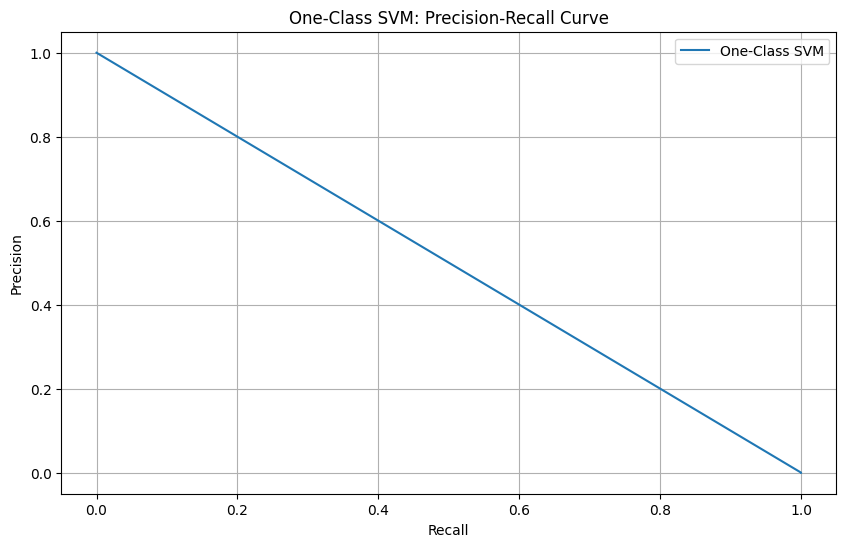

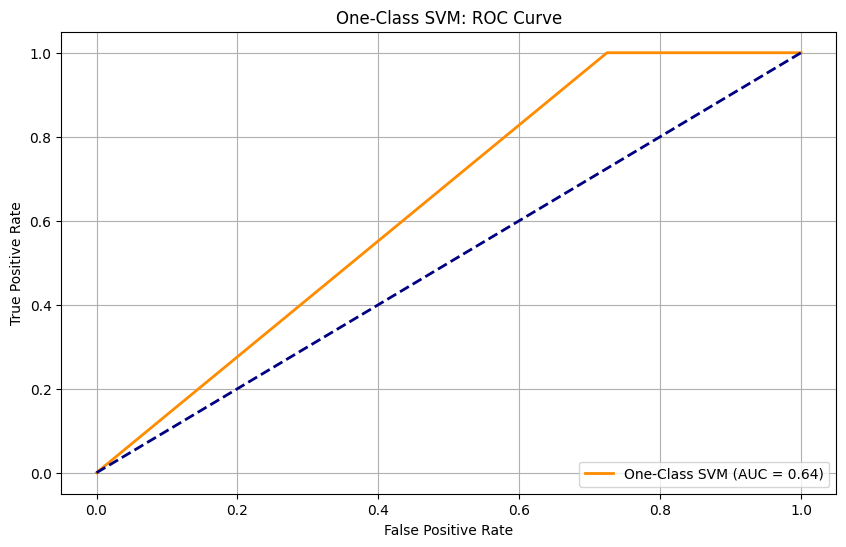

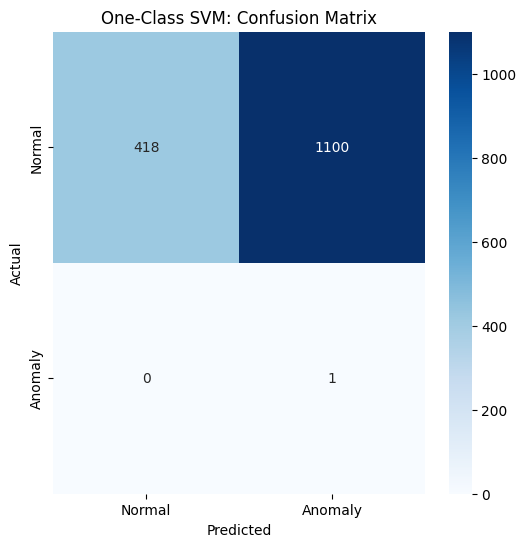

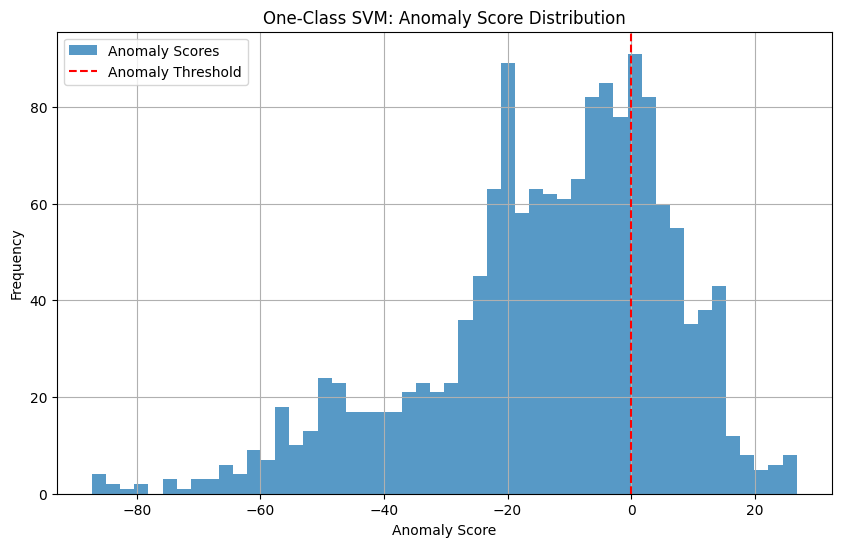

One-Class SVM Detected Anomalies: 1101


In [43]:
# Model 4: One-Class SVM Performance Test
# ===============================
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns

# Flatten Data
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Train the One-Class SVM
svm = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
svm.fit(X_train_flat)

# Predictions
svm_predictions = svm.predict(X_test_flat)
svm_anomalies = (svm_predictions == -1).astype(int)

# Visualizations
# 1. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test.astype(int), svm_anomalies)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label="One-Class SVM")
plt.title("One-Class SVM: Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test.astype(int), svm_anomalies)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'One-Class SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("One-Class SVM: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 3. Confusion Matrix
cm = confusion_matrix(y_test.astype(int), svm_anomalies)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("One-Class SVM: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Anomaly Score Histogram
svm_scores = svm.decision_function(X_test_flat)  # Decision function values
plt.figure(figsize=(10, 6))
plt.hist(svm_scores, bins=50, alpha=0.75, label="Anomaly Scores")
plt.axvline(0, color='red', linestyle='--', label="Anomaly Threshold")
plt.title("One-Class SVM: Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# Print Metrics
print(f"One-Class SVM Detected Anomalies: {np.sum(svm_anomalies)}")


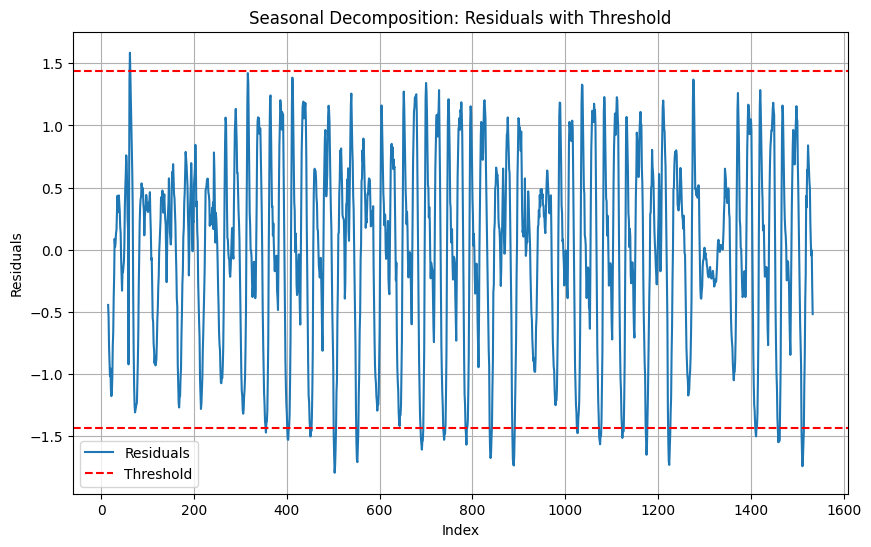

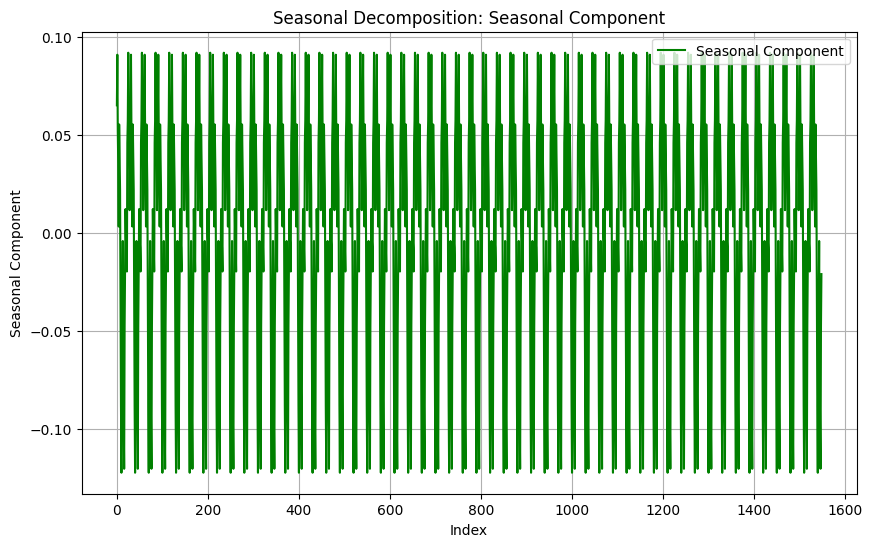

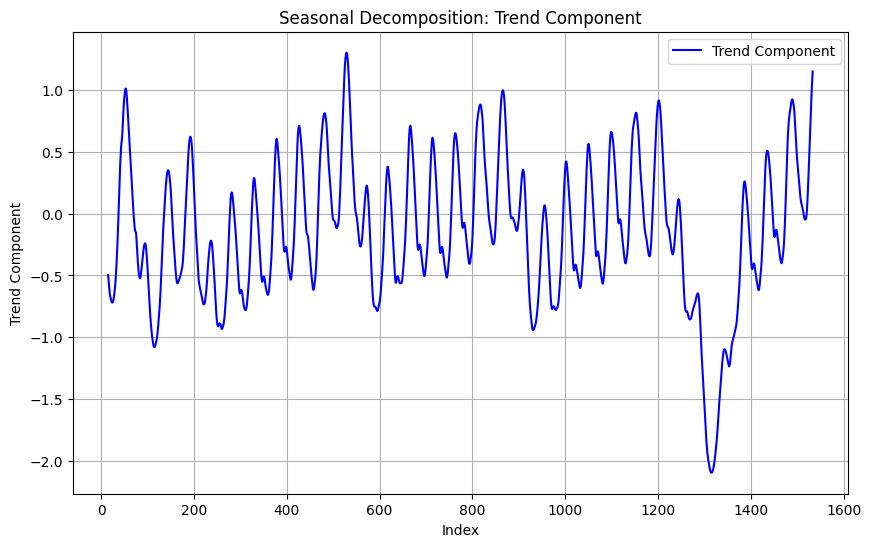

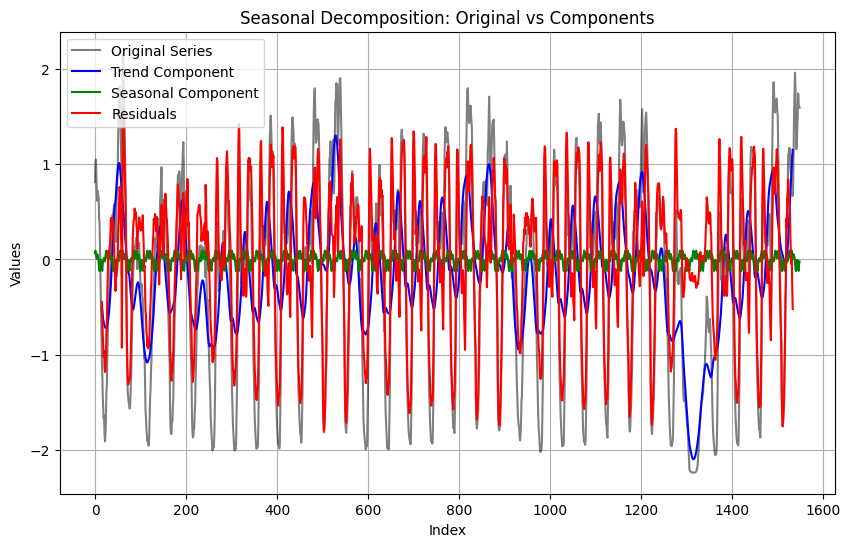

Seasonal Decomposition Residual Mean: -0.005489
Seasonal Decomposition Threshold (95th Percentile): 1.436642


In [44]:
# Model 5: Seasonal Decomposition Performance Test
# ===============================
# Model 5: Seasonal Decomposition Performance Test
# ===============================
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform Seasonal Decomposition
series = test_df['value']
decomposition = seasonal_decompose(series, model='additive', period=sequence_length)
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

# Threshold for Residuals
seasonal_threshold = np.percentile(np.abs(residual), 95)

# Visualizations

# 1. Residual Plot
plt.figure(figsize=(10, 6))
plt.plot(residual, label='Residuals')
plt.axhline(seasonal_threshold, color='red', linestyle='--', label='Threshold')
plt.axhline(-seasonal_threshold, color='red', linestyle='--')
plt.title("Seasonal Decomposition: Residuals with Threshold")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.legend()
plt.grid()
plt.show()

# 2. Seasonal Component Plot
plt.figure(figsize=(10, 6))
plt.plot(seasonal, label='Seasonal Component', color='green')
plt.title("Seasonal Decomposition: Seasonal Component")
plt.xlabel("Index")
plt.ylabel("Seasonal Component")
plt.legend()
plt.grid()
plt.show()

# 3. Trend Component Plot
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend Component', color='blue')
plt.title("Seasonal Decomposition: Trend Component")
plt.xlabel("Index")
plt.ylabel("Trend Component")
plt.legend()
plt.grid()
plt.show()

# 4. Original vs Decomposed Plot (Overlay)
plt.figure(figsize=(10, 6))
plt.plot(series, label='Original Series', color='black', alpha=0.5)
plt.plot(trend, label='Trend Component', color='blue')
plt.plot(seasonal, label='Seasonal Component', color='green')
plt.plot(residual, label='Residuals', color='red')
plt.title("Seasonal Decomposition: Original vs Components")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

# Print Metrics
print(f"Seasonal Decomposition Residual Mean: {np.mean(residual):.6f}")
print(f"Seasonal Decomposition Threshold (95th Percentile): {seasonal_threshold:.6f}")
